# PYTORCH VS. TENSORFLOW 

# Train and Evaluate a Pytorch model

In [2]:
import pathlib
from pprint import pprint
from matplotlib import pyplot as plt
from lips.benchmark import PowerGridBenchmark

In [3]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent
DATA_PATH = LIPS_PATH / "reference_data"
LOG_PATH = LIPS_PATH / "lips_logs.log"
CONFIG_PATH = LIPS_PATH / "lips" / "config" / "conf.ini"
BASELINES_PATH = LIPS_PATH / "trained_baselines"
TRAINED_MODEL_PATH = LIPS_PATH / "trained_models"

In [ ]:
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=CONFIG_PATH
                               )

## Instantiate the torch model

In [4]:
from lips.augmented_simulators.torch_models.fully_connected import TorchFullyConnected
from lips.augmented_simulators.torch_simulator import TorchSimulator
from lips.dataset.scaler import StandardScaler

In [5]:
#torch_fc = TorchFullyConnected(name="torch_FC",
#                               bench_config_name="Benchmark1",
#                               scaler=StandardScaler,
#                               log_path=LOG_PATH)

In [5]:
# params = {"input_size": benchmark1.train_dataset._size_x, "output_size": benchmark1.train_dataset._size_y}
torch_sim = TorchSimulator(name="torch_fc",
                           model=TorchFullyConnected,
                           scaler=StandardScaler,
                           log_path=LOG_PATH)
                           #**params)

### Train it 

In [ ]:
torch_sim.train(benchmark1.train_dataset, benchmark1.val_dataset, save_path=None, epochs=100)

#### Verify the model architecture

In [7]:
torch_sim.summary()

TorchFullyConnected(
  (input_layer): Linear(in_features=111, out_features=300, bias=True)
  (input_dropout): Dropout(p=0.0, inplace=False)
  (fc_layers): ModuleList(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=300, bias=True)
  )
  (dropout_layers): ModuleList(
    (0): Dropout(p=0.0, inplace=False)
    (1): Dropout(p=0.0, inplace=False)
    (2): Dropout(p=0.0, inplace=False)
  )
  (output_layer): Linear(in_features=300, out_features=40, bias=True)
)


In [8]:
print("Number of parameters of the model: ", torch_sim.count_parameters())

Number of parameters of the model:  316540


The parameters used for training and evaluation of this augmented simulator.

In [9]:
pprint(torch_sim.params)

{'activation': 'relu',
 'ckpt_freq': 50,
 'device': 'cpu',
 'dropout': 0.0,
 'epochs': 100,
 'eval_batch_size': 128,
 'input_dropout': 0.0,
 'layer': 'linear',
 'layers': (300, 300, 300, 300),
 'loss': {'name': 'MSELoss',
          'params': {'reduce': None,
                     'reduction': 'mean',
                     'size_average': None}},
 'metrics': ('MAELoss',),
 'name': 'torch_fc',
 'optimizer': {'name': 'adam', 'params': {'lr': 0.0003}},
 'save_freq': False,
 'shuffle': False,
 'train_batch_size': 128}


#### Visualize the performance 

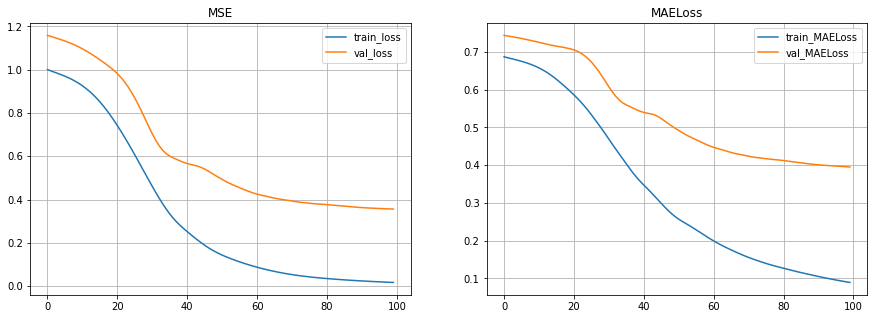

In [10]:
torch_sim.visualize_convergence()

## Evaluate

In [ ]:
# TODO: log the losses
torch_sim_metrics = benchmark1.evaluate_simulator(augmented_simulator=torch_sim,
                                                  eval_batch_size=128,
                                                  dataset="all",
                                                  shuffle=False
                                                 )

In [12]:
torch_sim_metrics["test"]["ML"]

{'MSE_avg': {'a_or': 5545.1455078125, 'a_ex': 15261.248046875},
 'MAE_avg': {'a_or': 45.997798919677734, 'a_ex': 71.28986358642578},
 'mape_90_avg': {'a_or': 0.19054710812401027, 'a_ex': 0.1885623161931562}}

In [13]:
torch_sim_metrics["test_ood_topo"]["ML"]

{'MSE_avg': {'a_or': 19668.666015625, 'a_ex': 35715.3125},
 'MAE_avg': {'a_or': 75.77731323242188, 'a_ex': 107.11604309082031},
 'mape_90_avg': {'a_or': 0.29361440542386846, 'a_ex': 0.2950267650547903}}

In [16]:
torch_sim.predict_time

0.001886129379272461

## Save & Load 

In [15]:
torch_sim.save(TRAINED_MODEL_PATH)

Load it

In [4]:
from lips.augmented_simulators.torch_models.fully_connected import TorchFullyConnected
from lips.augmented_simulators.torch_simulator import TorchSimulator
from lips.dataset.scaler import StandardScaler

torch_sim_test = TorchSimulator(name="torch_fc",
                                model=TorchFullyConnected,
                                scaler=StandardScaler,
                                log_path=LOG_PATH)

In [5]:
torch_sim_test.restore(path=TRAINED_MODEL_PATH)

# Train and evaluate a tensorflow model
## Fully Connected Neural Network

In [4]:
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.dataset.scaler import StandardScaler

In [5]:
tf_fc = TfFullyConnected(name="tf_fc",
                         bench_config_name="Benchmark1",
                         scaler=StandardScaler,
                         log_path=LOG_PATH)

### Train it

In [ ]:
tf_fc.train(train_dataset=benchmark1.train_dataset,
            val_dataset=benchmark1.val_dataset
           )

In [18]:
print("Number of parameters :", tf_fc.count_parameters())

Number of parameters : 316540


Save a visulaization of the architecture on disk

In [28]:
tf_fc.plot_model(path=".")

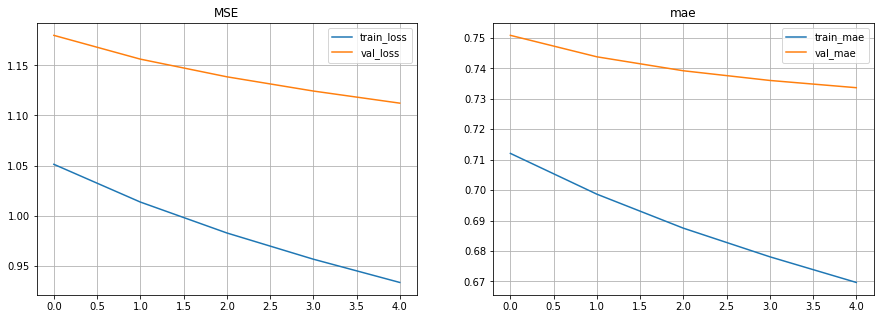

In [7]:
tf_fc.visualize_convergence()

### Evaluation 

In [20]:
# TODO: log the losses
tf_fc_metrics = benchmark1.evaluate_simulator(augmented_simulator=tf_fc,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False
                                             )

In [22]:
tf_fc_metrics["test"]["ML"]

{'MSE_avg': {'a_or': 23066.83203125, 'a_ex': 59156.79296875},
 'MAE_avg': {'a_or': 89.5516128540039, 'a_ex': 131.35769653320312},
 'mape_90_avg': {'a_or': 0.4733330523222685, 'a_ex': 0.4778364716470242}}

In [23]:
tf_fc_metrics["test_ood_topo"]["ML"]

{'MSE_avg': {'a_or': 40319.91796875, 'a_ex': 73951.9375},
 'MAE_avg': {'a_or': 122.29461669921875, 'a_ex': 169.42762756347656},
 'mape_90_avg': {'a_or': 0.5514428621530534, 'a_ex': 0.5490838075429202}}

In [26]:
tf_fc.predict_time

0.0887749195098877

### Save & Load 

In [9]:
tf_fc.save(TRAINED_MODEL_PATH)

Load it

In [12]:
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.dataset.scaler import StandardScaler

tf_fc = TfFullyConnected(name="tf_fc",
                         bench_config_name="Benchmark1",
                         scaler=StandardScaler,
                         log_path=LOG_PATH)

In [14]:
tf_fc.restore(TRAINED_MODEL_PATH)

# Train and evaluate a tensorflow model
## LeapNet Neural Network

In [4]:
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler import PowerGridScaler

In [5]:
leap_net = LeapNet(name="tf_leapnet",
                   bench_config_name="Benchmark1",
                   scaler=PowerGridScaler,
                   log_path=LOG_PATH)

### Train it

In [ ]:
leap_net.train(train_dataset=benchmark1.train_dataset,
               val_dataset=benchmark1.val_dataset
              )

Visualize and analyzethe convergence

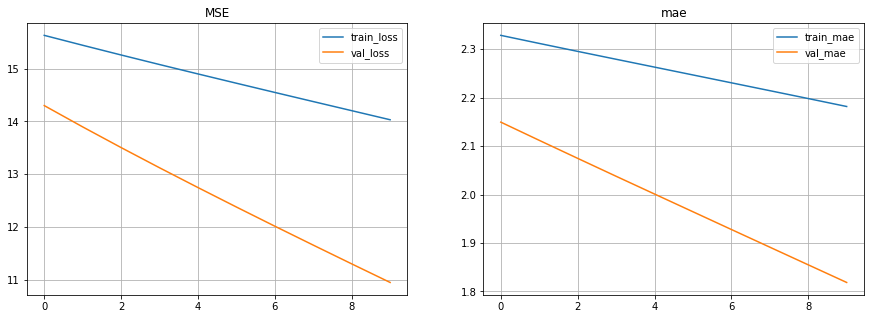

In [7]:
leap_net.visualize_convergence()

### Evaluation 

In [ ]:
# TODO: log the losses
tf_leapnet_metrics = benchmark1.evaluate_simulator(augmented_simulator=leap_net,
                                                   eval_batch_size=128,
                                                   dataset="all",
                                                   shuffle=False
                                                  )

In [9]:
tf_leapnet_metrics["test"]["ML"]

{'MSE_avg': {'a_or': 114318.578125, 'a_ex': 323436.0625},
 'MAE_avg': {'a_or': 221.4477996826172, 'a_ex': 364.8733215332031},
 'mape_90_avg': {'a_or': 0.902659864127636, 'a_ex': 0.949867993146181}}

In [10]:
tf_leapnet_metrics["test_ood_topo"]["ML"]

{'MSE_avg': {'a_or': 133465.09375, 'a_ex': 319799.0625},
 'MAE_avg': {'a_or': 232.8615264892578, 'a_ex': 369.9449157714844},
 'mape_90_avg': {'a_or': 0.9152731911838055, 'a_ex': 0.9683916045725347}}

In [11]:
leap_net.predict_time

0.12056970596313477

## Save and Restore 

In [12]:
leap_net.save(TRAINED_MODEL_PATH)

In [13]:
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler import PowerGridScaler

leap_net = LeapNet(name="tf_leapnet",
                   bench_config_name="Benchmark1",
                   scaler=PowerGridScaler,
                   log_path=LOG_PATH)

In [14]:
leap_net.restore(path=TRAINED_MODEL_PATH)